In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [33]:
from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark

from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from matplotlib import pyplot
from matplotlib.colors import TwoSlopeNorm
from joblib import Parallel, delayed

import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

In [64]:
CI = 'CI' in os.environ

updraft_list = np.geomspace(0.1, 10, 3 if CI else 7)
forg_list = np.linspace(0.05, 0.95, 3 if CI else 7)
models = ('Constant', 'CompressedFilmOvadnevaite', 'CompressedFilmRuehl', 'SzyszkowskiLangmuir')

In [65]:
def compute(key, settings):
    simulation = ParcelSimulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.modes[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(forg_list) * len(updraft_list)}')
output = dict(Parallel(verbose=10, n_jobs=-1)(
    delayed(compute)(f"w{w:.2f}_f{Forg:.2f}_"+model, Settings(
        dz = 1 * si.m, 
        n_sd_per_mode = 100, 
        model = model,
        aerosol = AerosolBetaCaryophylleneDark(Forg=Forg),
        w = w * si.m / si.s,
        spectral_sampling = spec_sampling.ConstantMultiplicity
    ))
    for w in updraft_list
    for Forg in forg_list
    for model in models
))

tasks scheduled: 196


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
<string>:56: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
/Users/claresinger/anaconda3/envs/pysdm/lib/python3.9/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
TOMS748 problem: not fa * fb < 0
	file: /Users/claresinger/Research/PySDM/PySDM/backends/impl_numba/toms748.py
TOMS748 problem: not fa * fb < 0
	file: /Users/claresinger/Research/PySDM/PySDM/backends/impl_numba/toms748.py
TOMS748 problem: not fa * fb < 0
	file: /Users/claresinger/Research/PySDM/PySDM/backends/impl_numba/toms748.py
TOMS748 problem: not fa * fb < 0
	file: /Users/claresinger/Research/PySDM/PySDM/backends/impl_numba/toms748.py
TOMS748 problem: not fa * fb < 0
	file: /Users/claresinger/Research/PySDM/PySDM/backends/impl_numba/toms748.py
TOMS748 problem: not fa * fb

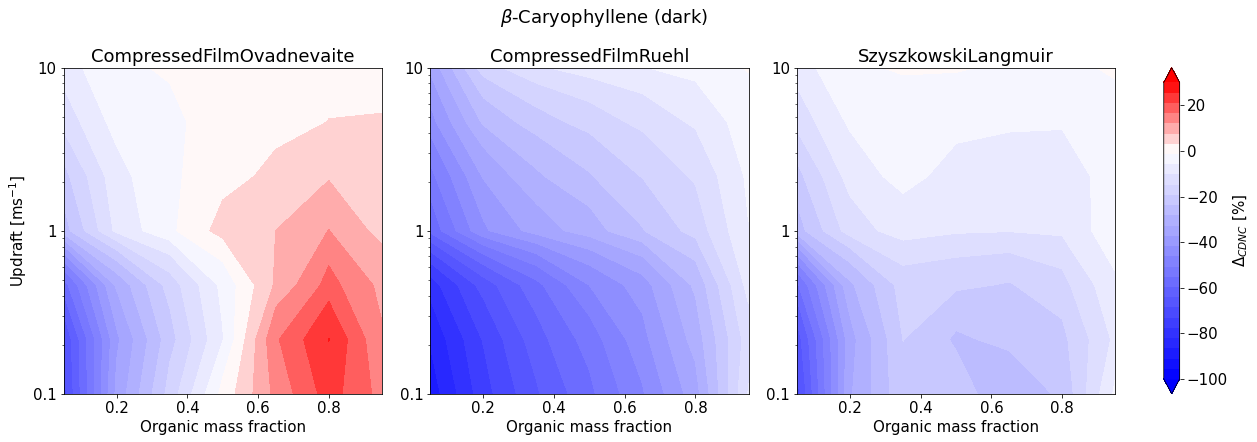

In [73]:
dCDNC = np.zeros((len(models), len(updraft_list), len(forg_list)))
for m in range(0,3):
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
            key = f"w{w:.2f}_f{Forg:.2f}_"
            var = 'n_c_cm3'
            z = np.array(output[key+"Constant"]['z'])
            wz = np.where(z == z[-1])[0][0]
            CDNC_film = np.array(output[key+models[m+1]][var])[wz]
            CDNC_bulk = np.array(output[key+"Constant"][var])[wz]
            dCDNC[m,i,j] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0

fig, axes = pyplot.subplots(1, 4, figsize=(20,6), gridspec_kw={"width_ratios":[1,1,1,0.05]})
fig.suptitle(r"$\beta$-Caryophyllene (dark)", y=1.02)
for i in range(0,3):
    ax = axes[i]
    ax.set_title(models[i+1])
    
    levs = np.linspace(-100,30,30)
    p = ax.contourf(forg_list, updraft_list, dCDNC[i], cmap="bwr", levels=levs, norm=TwoSlopeNorm(0), extend="both")
    
    ax.set_xlabel("Organic mass fraction")
    ax.set_yscale("log")
    ax.set_yticks([0.1,1,10])
    ax.set_yticklabels(["0.1","1","10"])
    if i == 0:
        ax.set_ylabel("Updraft [ms$^{-1}$]")

pyplot.colorbar(p, cax=axes[-1], ticks=[-100,-80,-60,-40,-20,0,20], label=r"$\Delta_{CDNC}$ [%]")
pyplot.rcParams.update({'font.size': 15})
pyplot.savefig("bCary_dCDNC_OVF_Updraft.png", dpi=200, facecolor="w", bbox_inches="tight")
pyplot.show()

############################

# dat = np.zeros((len(forg_list)+1, len(updraft_list)+1))
# dat[1:,0] = updraft_list
# dat[0,1:] = forg_list
# dat[1:,1:] = dCDNC
# print(dat)
# np.savetxt("Ryan_parcel_2D.csv", dat, fmt="%.4f", delimiter=',', 
#            header="W (m/s) (left col), Forg (top row), delta CDNC (%) (grid below), -, -, -, -, -, -, -, -", 
#            comments='Forg fractions in first row // Updraft speed in first column // dCDNC in grid\n')